## Pre-requisition 

In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import pickle as pkl

# pytorch
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models


import random
import frame_video_convert

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

os.makedirs(r'my_data/PicsForReport', exist_ok=True)

In [4]:
#Classic Segmentation method - GrubCut
#Using https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html
def GrubCut(img, rect):
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    return img

In [5]:
#Deep Learning segmentation method - DeepLabV3 +
#Reference Tutorial 5


def deeplabv3_resnet101(filename, device):
    # download and load the pre-trained model
    model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
    # put in inference mode
    model.eval();

#     print('Using: ',device)
    # load an image
    #filename

    input_image = Image.open(filename)
    # define the pre-processing steps
    # image->tensor, normalization
    preprocess = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # perform pre-processing
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model
    # send to device
    model = model.to(device)
    input_batch = input_batch.to(device)

    input_image

    # forward pass
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    
#     print("output shape: ", output.shape)
#     print("output_predictions shape: ", output_predictions.shape)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    r.putpalette(colors)
    return r, output_predictions, input_image

In [6]:
labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
 'bus', 'car', 'cat', 'chair', 'cow',
 'diningtable','dog', 'horse', 'motorbike', 'person','pottedplant','sheep', 'sofa', 'train', 'tvmonitor']
print(["{}: {}".format(i + 1, labels[i]) for i in range(len(labels))])

['1: aeroplane', '2: bicycle', '3: bird', '4: boat', '5: bottle', '6: bus', '7: car', '8: cat', '9: chair', '10: cow', '11: diningtable', '12: dog', '13: horse', '14: motorbike', '15: person', '16: pottedplant', '17: sheep', '18: sofa', '19: train', '20: tvmonitor']


In [7]:
def Present_SegmentImage_DeepLab(Segmented_image, output_predictions, input_image):
    # what labels were recognized?
    print('What is the label per Dict above:',np.unique(output_predictions.cpu().numpy()))
    Mask_Index = np.max(np.unique(output_predictions.cpu().numpy()))
    # create a mask
    mask = torch.zeros_like(output_predictions).float().to(device)
    mask[output_predictions == Mask_Index] = 1
    masked_img = input_image * mask.unsqueeze(2).byte().cpu().numpy()
    
    return Segmented_image, masked_img

### **Part 1 - Classic Vs. Deep Learning-based Semantic Segmentation**

### Section 1.1

In [8]:
#Lodaing Horses & Froges images 

Horse1 = cv2.imread(r'data/horses/horse1.png')
Horse2 = cv2.imread(r'data/horses/horse2.jpg')
                    
Frog1 = cv2.imread(r'data/frogs/frog1.jpg')
Frog2 = cv2.imread(r'data/frogs/frog2.jpg')

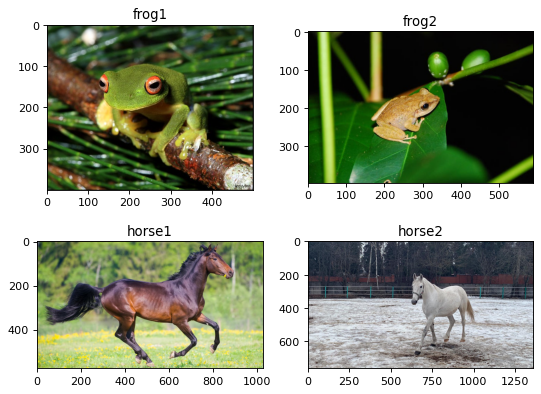

In [9]:
# display the images
fig = plt.figure(figsize=(8, 6), dpi=80) 
# horse1
ax = fig.add_subplot(2, 2 ,3) 
ax.imshow(cv2.cvtColor(Horse1, cv2.COLOR_BGR2RGB))
ax.set_title("horse1")
# _ = plt.axis('off')
#horse2
ax = fig.add_subplot(2, 2 ,4) 
ax.imshow(cv2.cvtColor(Horse2, cv2.COLOR_BGR2RGB))
ax.set_title("horse2")
# _ = plt.axis('off')
#frog1
ax = fig.add_subplot(2, 2 ,1) 
ax.imshow(cv2.cvtColor(Frog1, cv2.COLOR_BGR2RGB))
ax.set_title("frog1")
# _ = plt.axis('off')
# frog2
ax = fig.add_subplot(2, 2 ,2) 
ax.imshow(cv2.cvtColor(Frog2, cv2.COLOR_BGR2RGB))
ax.set_title("frog2")
# _ = plt.axis('off')

plt.savefig(r'my_data/PicsForReport/FrogsAndHorse_OriginalImage.jpg', bbox_inches='tight')

### Section 1.2

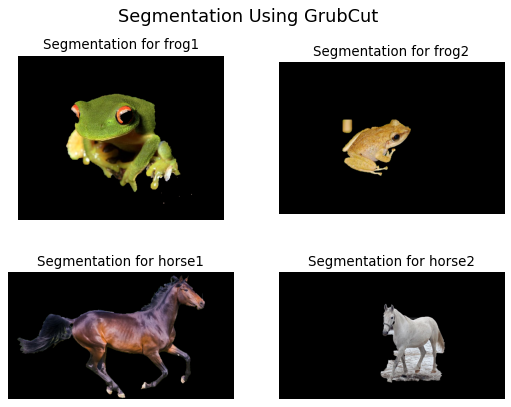

In [10]:
rect_Horse1 = (10,0,900,600)
Hourse1_Seg = GrubCut(Horse1,rect_Horse1)

rect_Horse2 = (590,190,410,480)
Hourse2_Seg = GrubCut(Horse2,rect_Horse2)

rect_Frog1 = (100,90,330,300)
Frog1_Seg = GrubCut(Frog1,rect_Frog1)

rect_Frog2 = (110,150,250,150)
Frog2_Seg = GrubCut(Frog2,rect_Frog2)


# display the Segmented images
fig = plt.figure(figsize=(8, 6), dpi=80) 
fig.suptitle('Segmentation Using GrubCut', fontsize=16)
# horse1
ax = fig.add_subplot(2, 2 ,3) 
ax.imshow(cv2.cvtColor(Hourse1_Seg, cv2.COLOR_BGR2RGB))
ax.set_title("Segmentation for horse1")
_ = plt.axis('off')
#horse2
ax = fig.add_subplot(2, 2 ,4) 
ax.imshow(cv2.cvtColor(Hourse2_Seg, cv2.COLOR_BGR2RGB))
ax.set_title("Segmentation for horse2")
_ = plt.axis('off')
#frog1
ax = fig.add_subplot(2, 2 ,1) 
ax.imshow(cv2.cvtColor(Frog1_Seg, cv2.COLOR_BGR2RGB))
ax.set_title("Segmentation for frog1")
_ = plt.axis('off')
# frog2
ax = fig.add_subplot(2, 2 ,2) 
ax.imshow(cv2.cvtColor(Frog2_Seg, cv2.COLOR_BGR2RGB))
ax.set_title("Segmentation for frog2")
_ = plt.axis('off')

plt.savefig(r'my_data/PicsForReport/FrogsAndHorse_SegementImage.jpg', bbox_inches='tight')

Segmentation Using Deep Lab V3

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.5.0


What is the label per Dict above: [ 0 13]


Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.5.0


What is the label per Dict above: [ 0 13]


Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.5.0


What is the label per Dict above: [0 3]


Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.5.0


What is the label per Dict above: [0 3]


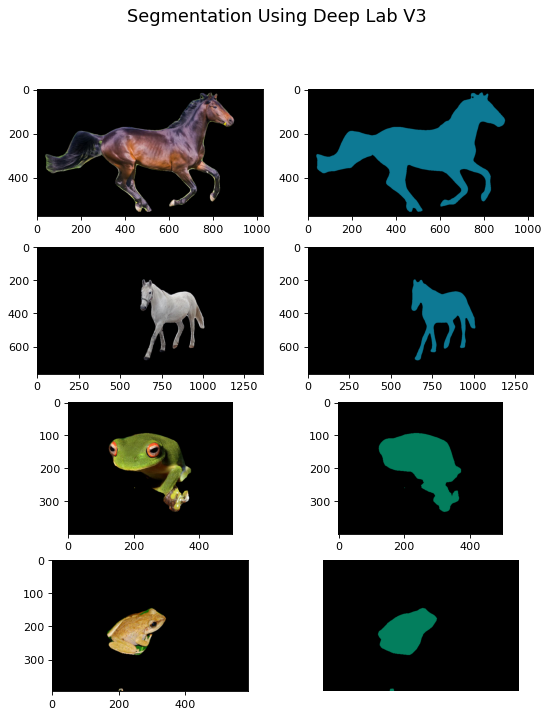

In [11]:
#Present all the images to segment together
# display the Segmented images
ImageToSegment = [r'data/horses/horse1.png', r'data/horses/horse2.jpg', r'data/frogs/frog1.jpg', r'data/frogs/frog2.jpg']
fig = plt.figure(figsize=(8, 10), dpi=80) 
fig.suptitle('Segmentation Using Deep Lab V3', fontsize=16)
for j in range(0,4):
    Segmented_image, output_predictions, input_image = deeplabv3_resnet101(ImageToSegment[j], device)
    Segmented_image, masked_img = Present_SegmentImage_DeepLab(Segmented_image, output_predictions, input_image)
    ax = fig.add_subplot(4, 2 ,(2*j)+1) 
    ax.imshow(masked_img)
    ax = fig.add_subplot(4, 2 ,(2*j)+2) 
    ax.imshow(Segmented_image)    
_ = plt.axis('off')
    
plt.savefig(r'my_data/PicsForReport/FrogsAndHorse_SegementImageDeepLabV3.jpg', bbox_inches='tight')    

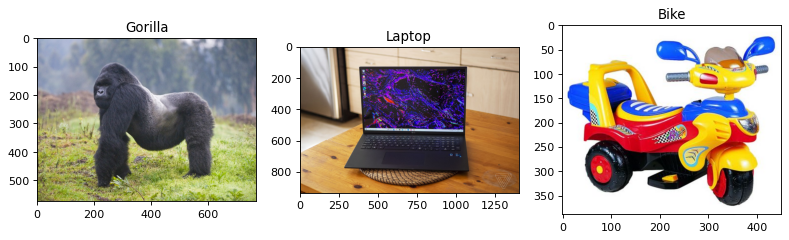

In [12]:
Gorilla = cv2.imread(r'my_data/SegmentImages/Gorilla.jpg')
Laptop = cv2.imread(r'my_data/SegmentImages/Laptop.jpg')              
Bike = cv2.imread(r'my_data/SegmentImages/BabyBike.jpg')

# display the images
fig = plt.figure(figsize=(12, 10), dpi=80) 
# horse1
ax = fig.add_subplot(1, 3 ,1) 
ax.imshow(cv2.cvtColor(Gorilla, cv2.COLOR_BGR2RGB))
ax.set_title("Gorilla")
# _ = plt.axis('off')
#frog1
ax = fig.add_subplot(1, 3 ,2) 
ax.imshow(cv2.cvtColor(Laptop, cv2.COLOR_BGR2RGB))
ax.set_title("Laptop")
# _ = plt.axis('off')
# frog2
ax = fig.add_subplot(1, 3 ,3) 
ax.imshow(cv2.cvtColor(Bike, cv2.COLOR_BGR2RGB))
ax.set_title("Bike")
# _ = plt.axis('off')

plt.savefig(r'my_data/PicsForReport/RandomPictures.jpg', bbox_inches='tight')

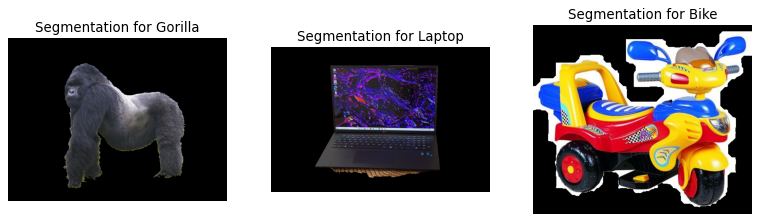

In [13]:
rect_Gorilla = (10,10,650,550)
Gorilla_Seg = GrubCut(Gorilla,rect_Gorilla)

rect_Laptop = (250,50,1000,850)
Laptop_Seg = GrubCut(Laptop,rect_Laptop)

rect_Bike = (0,0,450,380)
Bike_Seg = GrubCut(Bike,rect_Bike)


# display the Segmented images
fig = plt.figure(figsize=(12, 9), dpi=80) 
# Gorilla
ax = fig.add_subplot(1, 3 ,1) 
ax.imshow(cv2.cvtColor(Gorilla_Seg, cv2.COLOR_BGR2RGB))
ax.set_title("Segmentation for Gorilla")
_ = plt.axis('off')
# Laptop
ax = fig.add_subplot(1, 3 ,2) 
ax.imshow(cv2.cvtColor(Laptop_Seg, cv2.COLOR_BGR2RGB))
ax.set_title("Segmentation for Laptop")
_ = plt.axis('off')
# Bike
ax = fig.add_subplot(1, 3 ,3) 
ax.imshow(cv2.cvtColor(Bike_Seg, cv2.COLOR_BGR2RGB))
ax.set_title("Segmentation for Bike")
_ = plt.axis('off')

plt.savefig(r'my_data/PicsForReport/RandomPictures_GrubCutSegmentation.jpg', bbox_inches='tight')

Segmentation Using Deep Lab V3

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.5.0


What is the label per Dict above: [0]


Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.5.0


What is the label per Dict above: [ 0 11]


Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.5.0


What is the label per Dict above: [ 0 14]


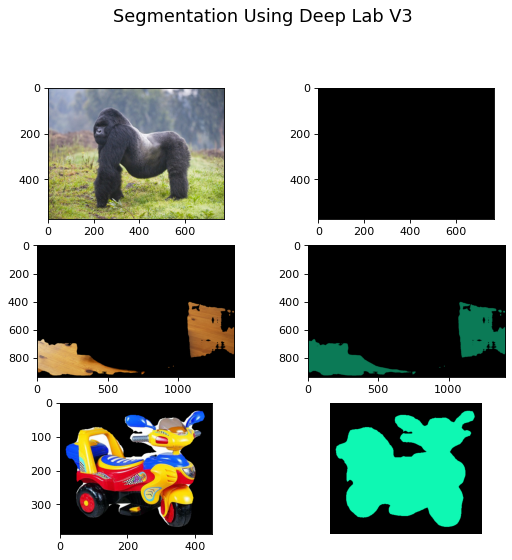

In [14]:
ImageToSegment = [r'my_data/SegmentImages/Gorilla.jpg', r'my_data/SegmentImages/Laptop.jpg', r'my_data/SegmentImages/BabyBike.jpg']

fig = plt.figure(figsize=(8, 10), dpi=80) 
fig.suptitle('Segmentation Using Deep Lab V3', fontsize=16)
for j in range(0,3):
    Segmented_image, output_predictions, input_image = deeplabv3_resnet101(ImageToSegment[j], device)
    Segmented_image, masked_img = Present_SegmentImage_DeepLab(Segmented_image, output_predictions, input_image)
    ax = fig.add_subplot(4, 2 ,(2*j)+1) 
    ax.imshow(masked_img)
    ax = fig.add_subplot(4, 2 ,(2*j)+2) 
    ax.imshow(Segmented_image)    
_ = plt.axis('off')
    
plt.savefig(r'my_data/PicsForReport/RandomPics_SegementImageDeepLabV3.jpg', bbox_inches='tight')  

## **Part 2 - Analayzing a Pre-trained CNN**

In [15]:
# Helper functions

def pre_processing(image, device=torch.device("cpu")):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    
    # perform pre-processing
    input_tensor  = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) 
    
    return input_batch

def pre_processing_without_resize(image, device=torch.device("cpu")):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
   #transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    
    # perform pre-processing
    input_tensor  = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) 
    
    return input_batch


def deprocess(image, device=torch.device("cpu")):
    return image * torch.tensor([0.229, 0.224, 0.225]).to(device) + torch.tensor([0.485, 0.456, 0.406]).to(device)


def plot_images(names):
    fig = plt.figure()

    for i in range(len(names)):
        img = Image.open(names[i])
        a = fig.add_subplot(1, 2, i+1)
        imgplot = plt.imshow(img)
        a.set_axis_off()
        a.set_title(names[i].split('/')[-1], fontsize=25)
    plt.tight_layout()
        

### Section 2.1

In [16]:
# download and load the pre-trained model
model=models.vgg16(pretrained=True, progress=True)
# put in inference mode
model.eval();

### Section 2.2
#### Load & Display Images from the internet

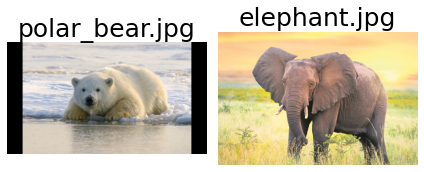

In [17]:
with open("./data/imagenet1000_clsidx_to_labels.txt", "r") as f:
    labels = [s.strip() for s in f.readlines()]
    
internet_animals=['./my_data/polar_bear.jpg','./my_data/elephant.jpg']

plot_images(internet_animals)

### Sections 2.3 & 2.4

In [18]:
def pre_process_and_predict(image_path, labels, model, device=torch.device("cpu")):
    # Load
    img = Image.open(image_path)
    # pre-processing
    input_batch = pre_processing(img, device)
    
    # send to device
    model = model.to(device)
    input_batch = input_batch.to(device)
    
    # forward pass
    with torch.no_grad():
        output = model(input_batch)
        output = output.squeeze()
        output_predictions = output.argmax()
        top_prob, top_cat = torch.topk(output, 1)
        img_name = image_path.split('/')[-1]
        print("The classification for {0} image is {1}".format(img_name, labels[top_cat]))
        print("score: ",top_prob.item())

The classification for polar_bear.jpg image is 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
score:  32.134464263916016
The classification for elephant.jpg image is 386: 'African elephant, Loxodonta africana',
score:  27.92523193359375


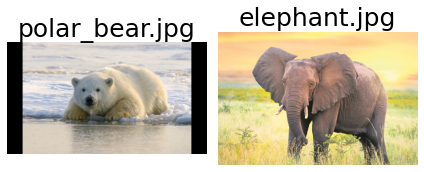

In [19]:
plot_images(internet_animals)
for i, path in enumerate(internet_animals):
    pre_process_and_predict(path, labels,model, device)

### Section 2.5
#### segment the animal


In [20]:
# download and load the pre-trained model
v3_model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
# put in inference mode
v3_model.eval();

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.5.0


In [21]:
bear_img = Image.open(internet_animals[0])

# perform pre-processing
input_batch = pre_processing_without_resize(bear_img, device)

# send to device
v3_model = v3_model.to(device)
input_batch = input_batch.to(device)

# forward pass
with torch.no_grad():
    output = v3_model(input_batch)['out'][0]
output_predictions = output.argmax(0)

In [22]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(bear_img.size)
r.putpalette(colors)

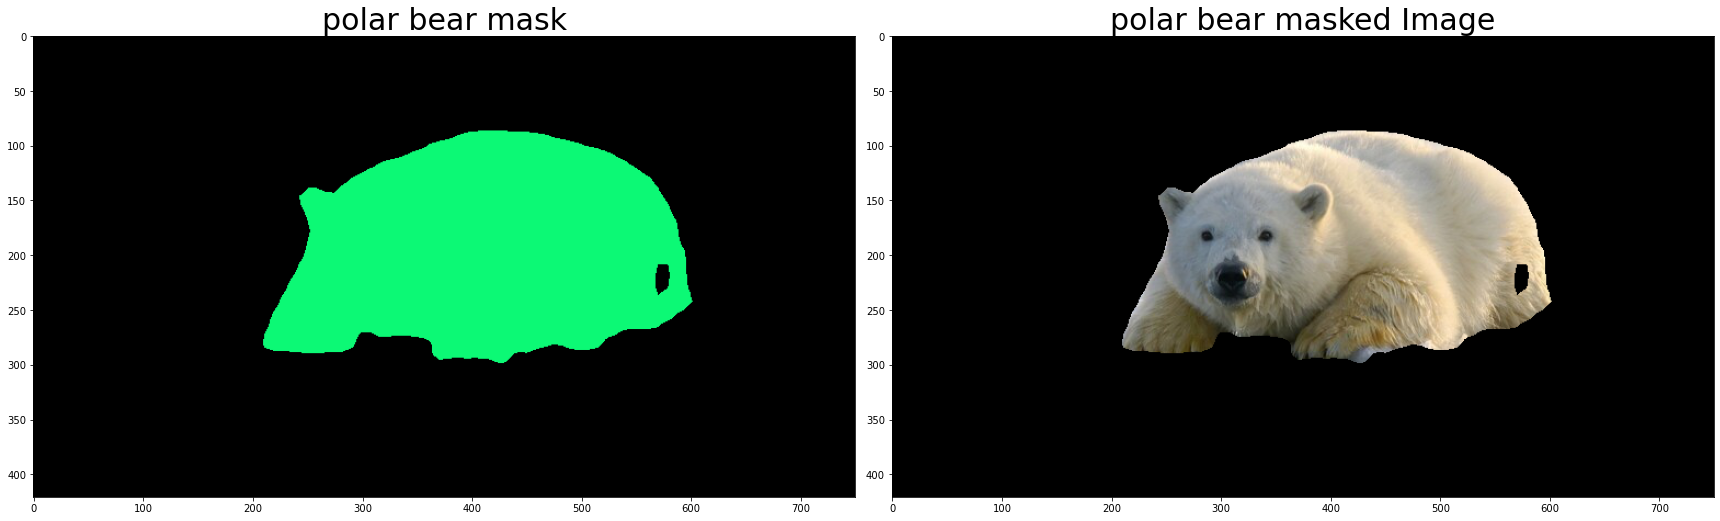

In [23]:
# create a mask
mask = torch.zeros_like(output_predictions).float().to(device)
mask[output_predictions == 12] = 1 
# mask[output_predictions == 15] = 1 
mask= mask.unsqueeze(2).byte().cpu().numpy()

masked_img = bear_img * mask

#plot
fig = plt.figure(figsize=(24,12))
ax = fig.add_subplot(121)
ax.imshow(r)
ax.set_title("polar bear mask", fontsize=30)
ax = fig.add_subplot(122)
ax.imshow(masked_img)
ax.set_title('polar bear masked Image', fontsize=30);
plt.tight_layout()

### Section 2.6
#### Put the the animal in a different habitat

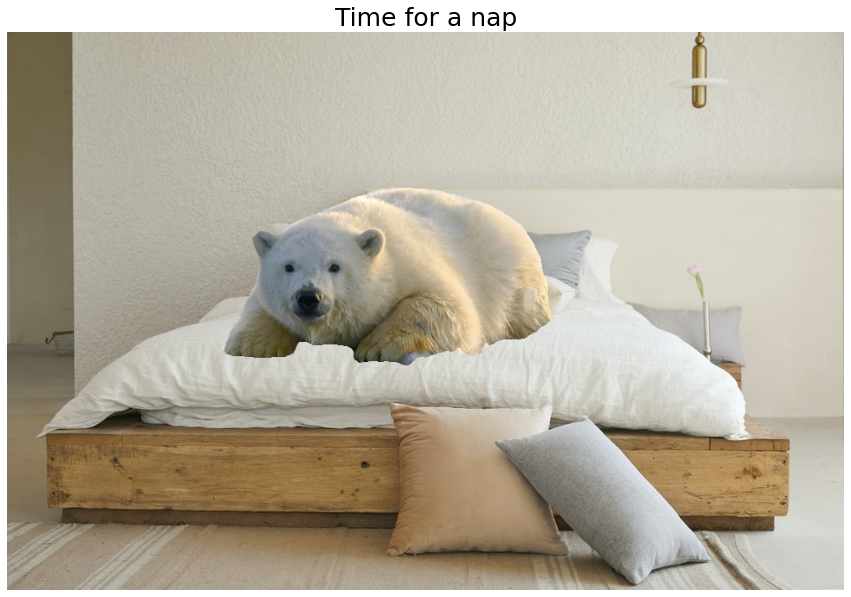

In [24]:
bed_img=cv2.imread('./my_data/bed1.jpg')
bed=bed_img.copy()
# resize the polar bear image mask to the same size of the bed image
h,w=np.shape(masked_img)[0],np.shape(masked_img)[1]
resized_mask_img = np.zeros_like(bed_img)
resized_mask_img[100:h+100,50:w+50,:] = masked_img

bed = cv2.cvtColor(bed, cv2.COLOR_BGR2RGB)

# add the polar bear to the bed
bed[np.where(resized_mask_img>0)] = resized_mask_img[np.where(resized_mask_img >0)]

#plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(bed)
ax.set_title('Time for a nap', fontsize=25);
ax.set_axis_off()

# save to output dir
a= Image.fromarray(bed)
a.save('../output/napping_bear.jpg')

### Section 2.7
####  Feed the new image to the network

In [25]:
new_image_path='../output/napping_bear.jpg'
pre_process_and_predict(new_image_path, labels, model, device)

The classification for napping_bear.jpg image is 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
score:  20.904523849487305


### Section 2.8
#### Plot first 3 filters in the first layer of VGG16
#### And plot their response

In [26]:
# The following two function taken from the link in the tutorial
# https://github.com/Niranjankumar-c/DeepLearning-PadhAI/tree/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch


def plot_filters_multi_channel(t):
    
    # get the number of kernals
    num_kernels = t.shape[0]    
    
    # define number of columns for subplots
    num_cols = 12
    # rows = num of kernels
    num_rows = num_kernels
    
    # set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    # looping through all the kernels
    for i in range(3):   # we need 3 kernals
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        # for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().numpy(), np.float32)
        # standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()

    
    
def plot_weights(model, layer_num):
    
    # extracting the model features at the particular layer number
    layer = model.features[layer_num]
    print("The first layer of VGG16 is:   \n {}\n".format(layer))
    print("The first 3 Filters of the VGG16's first Layer :")

    # checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        # getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data
        # print(" {}".format(weight_tensor))
        # print("weight_tensor shape: {}".format(weight_tensor.size()))

        if weight_tensor.shape[1] == 3: 
            plot_filters_multi_channel(weight_tensor)
        else:
            print("Can only plot weights with three channels")
    else:
        print("Can only visualize layers which are convolutional")

        
def filter_outputs(image, model, layer_to_visualize):
    modulelist = list(model.features.modules())
    #print("modil list",modulelist[1])
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
        
    fig = plt.figure(figsize=(24, 8))

    for i in range(3):
        ax = fig.add_subplot(1,3, i+1)
        imgplot = ax.imshow(filters[i])
        ax.set_title('Conv2d, filter response {} '.format(i), fontsize=30);
        ax.set_axis_off()
    plt.tight_layout()

The first layer of VGG16 is:   
 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

The first 3 Filters of the VGG16's first Layer :


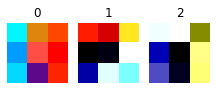

In [27]:
# plot the first 3 filters
plot_weights(model, 0)

Filters response for the polar bear original image: 


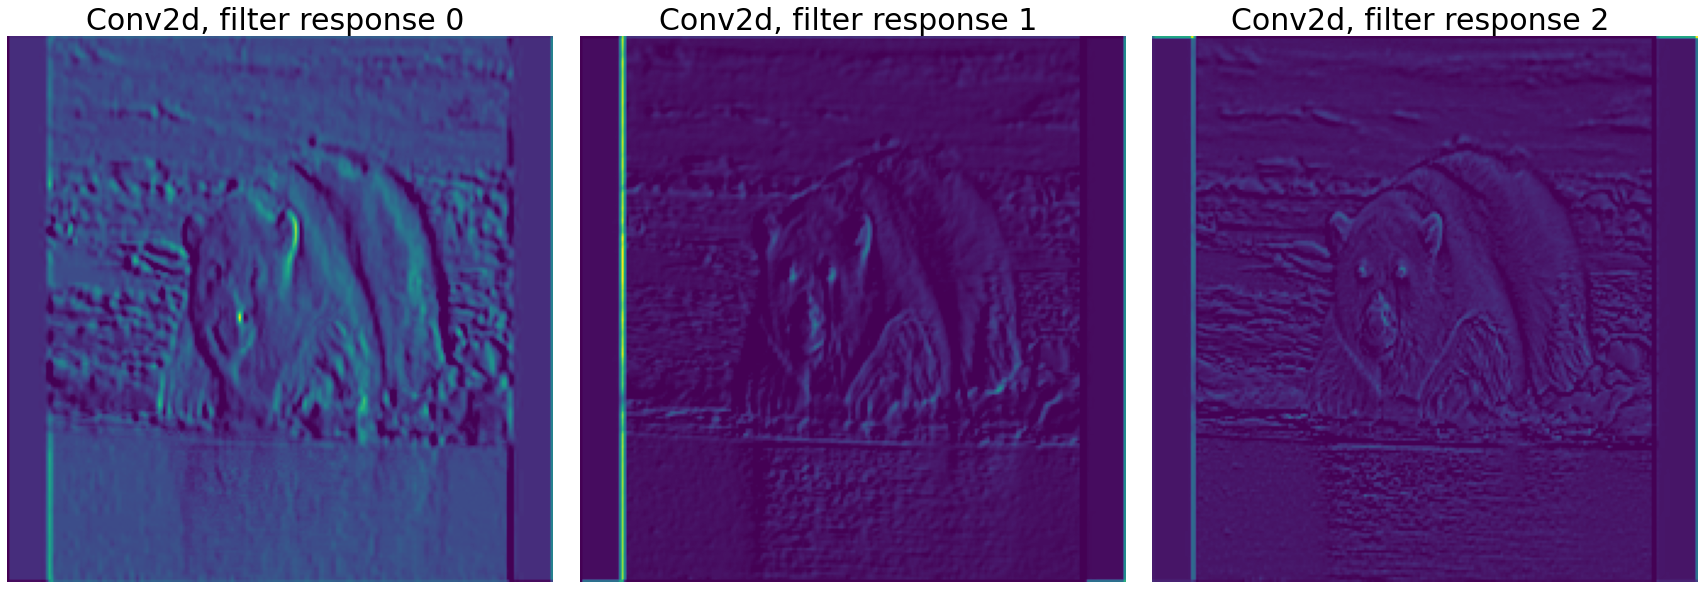

In [28]:
img1 = Image.open(internet_animals[0])
prep_im1= pre_processing(img1, device).to(device)
filter_outputs(prep_im1, model, 0)
print( "Filters response for the polar bear original image: ")

Filters response for the polar bear in a new habitat image: 


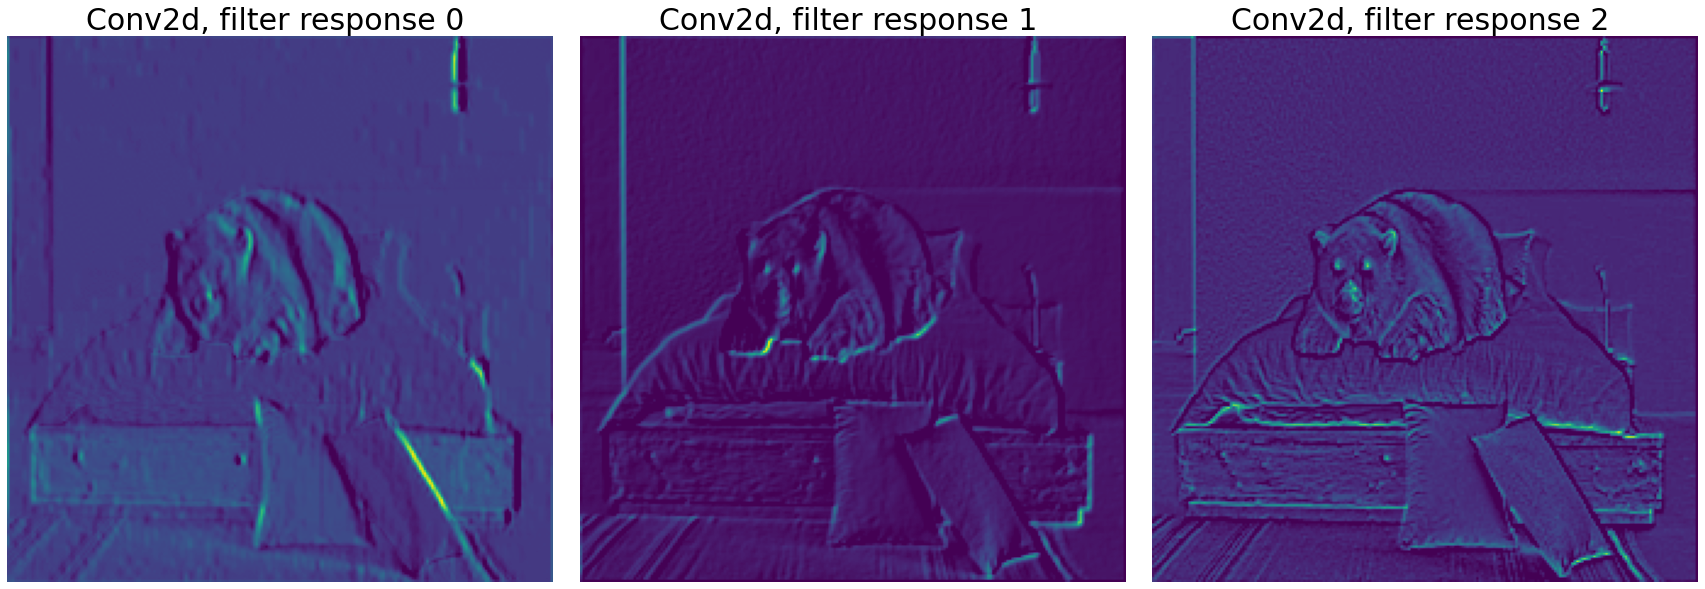

In [29]:
img2 = Image.open(new_image_path)
prep_im2= pre_processing(img2, device).to(device)
filter_outputs(prep_im2, model, 0)
print( "Filters response for the polar bear in a new habitat image: ")

### Section 2.10
#### Extract and save feature vectors from a fully-connected layer


In [30]:
import glob

def extract_features_vector(img,modulelist,layer_number):

    with torch.no_grad():
        for count, layer in enumerate(modulelist[0:layer_number]):
            
            img = layer(img)
            if count == 31 :
                img=img.view(img.size(0), -1)

        img=img.squeeze(0).cpu().numpy() 
        return img
            
                                    

def create_array_of_feature_vectors(folder_path, modulelist, layer_number, target_path, device=torch.device("cpu")):
    
    # list of files in a folder
    files_list=glob.glob1(folder_path,'*.jpg')
    
    feature_vec_list=[]
    for i, path in enumerate(files_list):
        image_path= (folder_path +path)
        
        img= Image.open(image_path)
        # pre_processing
        input_batch=pre_processing(img,device)
        input_batch = input_batch.to(device)
        # extract_features_vector
        feature_vec= extract_features_vector(input_batch,modulelist,layer_number)
        feature_vec_list.append(feature_vec)
    # creat the feature vector array
    feature_vec_array = np.stack(feature_vec_list)
    
    #saving in output folder
    with open(target_path,'wb') as f:
        pkl.dump(feature_vec_array, f)
    
    return feature_vec_array
    

In [31]:
# create a modulelist of all layers
features = list(model.features)
features.append(model.avgpool)
classifier = list(model.classifier)

modulelist=features+classifier

dogs_folder_path='./data/dogs/'
cats_folder_path='./data/cats/'

FC_layer_number=35


dogs_feature_vec_array= create_array_of_feature_vectors(dogs_folder_path, modulelist, FC_layer_number,'../output/dogs_train_vec.pkl' ,device)
print("shape of the Dogs feature vec array: ",np.shape(dogs_feature_vec_array))
cats_feature_vec_array= create_array_of_feature_vectors(cats_folder_path, modulelist, FC_layer_number,'../output/cats_train_vec.pkl' ,device)
print("shape of the Cats feature vec array: ",np.shape(cats_feature_vec_array))

shape of the Dogs feature vec array:  (10, 4096)
shape of the Cats feature vec array:  (10, 4096)


### Section 2.11
#### Build a Support Vector Machine (SVM) classifier

In [32]:
# create the train set of the feature vectors we found above
Xtrain= np.concatenate((dogs_feature_vec_array, cats_feature_vec_array), axis=0)
ytrain=['dog'] * 10 + ['cat'] * 10

# fit 
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
clf.fit(Xtrain, ytrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

shape of the Dogs feature vec array:  (2, 4096)
shape of the Dogs feature vec array:  (2, 4096)


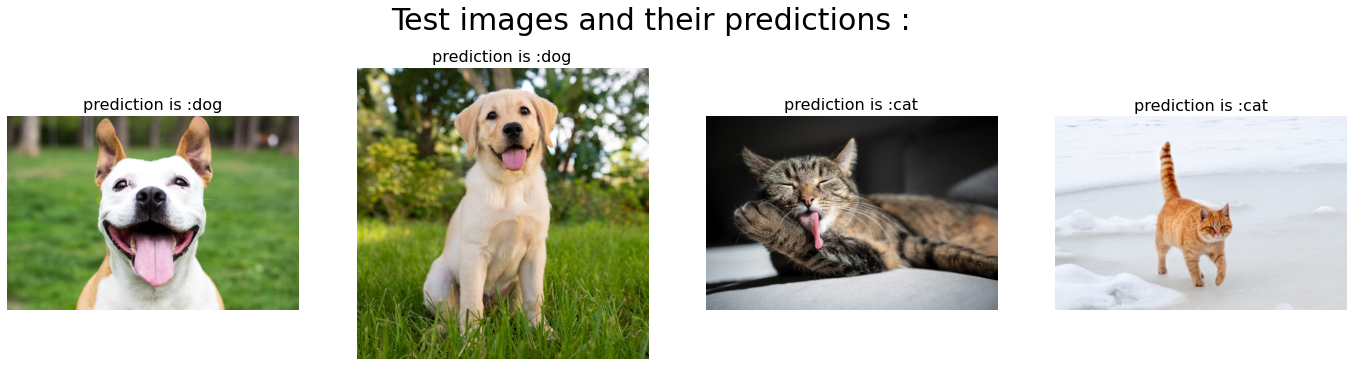

In [33]:
# create feature vectors for the test set
dogs_test_folder_path = './my_data/dogs_test/'
dogs_test= create_array_of_feature_vectors(dogs_test_folder_path, modulelist, FC_layer_number,'./my_data/test_feature_vecs/dogs_test_vec.pkl' ,device)
print("shape of the Dogs feature vec array: ",np.shape(dogs_test))

cats_test_folder_path = './my_data/cats_test/'
cats_test= create_array_of_feature_vectors(cats_test_folder_path, modulelist, FC_layer_number,'./my_data/test_feature_vecs/cats_test_vec.pkl' ,device)
print("shape of the Dogs feature vec array: ",np.shape(cats_test))


# create the test set 
Xtest=np.concatenate((dogs_test, cats_test), axis=0)

# predict
predictions= clf.predict(Xtest)

# plot results

fig = plt.figure(figsize=(24,6 ))
fig.suptitle('Test images and their predictions : ', fontsize=30)

test_images_path=['./my_data/dogs_test/dog1.jpg','./my_data/dogs_test/dog2.jpg','./my_data/cats_test/cat1.jpg','./my_data/cats_test/cat2.jpg']
for i, path in enumerate(test_images_path):
    img= Image.open(path)
    ax = fig.add_subplot(1,4, i+1)
    imgplot = ax.imshow(img)
    ax.set_title("prediction is :" + predictions[i], fontsize=16);
    ax.set_axis_off()

## Part 3 - Jurrasic Fishbach 

In [37]:
#device= "cpu"

In [38]:
def segment_and_save(OriginalImagesRoot, SegmentImagesOutputRoot, ImageName, Model, GrubCutRect = (0,0,0,0)):
    for j, files in enumerate(os.listdir(OriginalImagesRoot)):
        path = os.path.join(OriginalImagesRoot, files) 
#         print(path)  
        if Model == 'Deep':
            Segmented_image, output_predictions, input_image = deeplabv3_resnet101(path, device)
            # what labels were recognized?
            print('What is the label per Dict above:',np.max(np.unique(output_predictions.cpu().numpy())))
            Mask_Index = np.max(np.unique(output_predictions.cpu().numpy()))
            # create a mask
            mask = torch.zeros_like(output_predictions).float().to(device)
            mask[output_predictions == Mask_Index] = 1
            if ImageName == 'MyVideo':
                mask[:,-150:] = 0
            masked_img = input_image * mask.unsqueeze(2).byte().cpu().numpy()
            cv2.imwrite(os.path.join(SegmentImagesOutputRoot, "{:04d}".format(j)+".jpg" ), cv2.cvtColor(masked_img, cv2.COLOR_RGB2BGR))
        
        if Model == 'Classic':
            ClassicImage = cv2.imread(path)   
            masked_img = GrubCut(ClassicImage,GrubCutRect)
            cv2.imwrite(os.path.join(SegmentImagesOutputRoot, "{:04d}".format(j)+".jpg" ), masked_img)  
    

In [39]:
def Sec3(vid_path,HighLevelName, ImageName, Model, GrubCutRect = (0,0,0,0)):
    if Model == 'Deep':
        print('Using Deep Lab V3 Model')
    if Model == 'Classic':
        print('Using GrubCut Model')
    #The root for saving the frames
    OriginalImagesRoot = r'my_data/{}/img'.format(HighLevelName)
    #The root for saving the Segmented frames
    SegmentImagesOutputRoot = r'my_data/{}/seg'.format(HighLevelName)
    os.makedirs(SegmentImagesOutputRoot, exist_ok=True)
    #Convert Video to frames take the video from vid_path and save at OutputRoot
    frame_video_convert.video_to_image_seq(vid_path, output_path=OriginalImagesRoot)
    segment_and_save(OriginalImagesRoot, SegmentImagesOutputRoot, ImageName, Model, GrubCutRect)


    return SegmentImagesOutputRoot, OriginalImagesRoot

def EmbeddingFrames(ImageSegmentPath1, ImageSegmentPath2, BackgroundPath, 
                    VideoOffset1, VideoOffset2, FolderName, VideoScale1 = (1,1), VideoScale2 = (1,1)):
    #Section 4
    DirToSaveEmbedding = r'my_data/{}/CombinationSegAndBackground'.format(FolderName)
    os.makedirs(DirToSaveEmbedding, exist_ok=True)
    BackgroundImage = cv2.imread(BackgroundPath)
    BackgroundImage = cv2.resize(BackgroundImage, (1200,600))
    
    for (j, files1), (i, files2) in zip(enumerate(os.listdir(ImageSegmentPath1)), enumerate(os.listdir(ImageSegmentPath2))):     
        #Pre processing for 1st scene
        path1 = os.path.join(ImageSegmentPath1,files1)
        SegImage1 = cv2.imread(path1)
        SegImage1 = cv2.resize(SegImage1, (int(np.round(VideoScale1[1]*(SegImage1.shape[1]))),
                                         int(np.round(VideoScale1[0]*(SegImage1.shape[0])))))
        SegImageSameSize1 = np.zeros_like(BackgroundImage)
        mask = np.ones_like(BackgroundImage) * 255
        ImgMask1 = np.ones_like(SegImage1)*255
        ImgMask1[SegImage1 > 10] = 0 #The threshold is 10 to avoide noises with the segmentation
        SegImageSameSize1[VideoOffset1[0]:VideoOffset1[0]+ImgMask1.shape[0],
                          VideoOffset1[1]:VideoOffset1[1]+ImgMask1.shape[1],:] = SegImage1
        

        #Pre processing for 2nd scene
        path2 = os.path.join(ImageSegmentPath2,files2)
        SegImage2 = cv2.imread(path2)
        SegImage2 = cv2.resize(SegImage2, (int(np.round(VideoScale2[1]*(SegImage2.shape[1]))),
                                         int(np.round(VideoScale2[0]*(SegImage2.shape[0])))))
        SegImageSameSize2 = np.zeros_like(BackgroundImage)
        ImgMask2 = np.ones_like(SegImage2)*255

        ImgMask2[SegImage2 > 10] = 0 #The threshold is 10 to avoide noises with the segmentation
        SegImageSameSize2[VideoOffset2[0]:VideoOffset2[0]+ImgMask2.shape[0],
                          VideoOffset2[1]:VideoOffset2[1]+ImgMask2.shape[1],:] = SegImage2
        
        
        mask[VideoOffset1[0]:VideoOffset1[0]+ImgMask1.shape[0],
                          VideoOffset1[1]:VideoOffset1[1]+ImgMask1.shape[1],:] = ImgMask1
        mask[VideoOffset2[0]:VideoOffset2[0]+ImgMask2.shape[0],
                          VideoOffset2[1]:VideoOffset2[1]+ImgMask2.shape[1],:] = ImgMask2
        masked = cv2.bitwise_and(BackgroundImage, mask)

        BGWithSeg = masked + SegImageSameSize1 + SegImageSameSize2
        cv2.imwrite(os.path.join(DirToSaveEmbedding, "{:04d}".format(j)+".jpg" ), BGWithSeg)
    
    OutputVideoPath = r'../output/{}_video.mp4'.format(FolderName)
    frame_video_convert.image_seq_to_video(DirToSaveEmbedding, OutputVideoPath)
    print('Finish Embedding')
    return SegmentImagesOutputRoot, DirToSaveEmbedding, OriginalImagesRoot

In [40]:
#Display two Frames
def Display_Two_Frames(Directory):
    List = random.choices(os.listdir(Directory), k=5)
    print('Display files', List)
    FirstFrame = cv2.imread(os.path.join(Directory, List[0]))
    SecondFrame = cv2.imread(os.path.join(Directory, List[1])) 
    # display the images
    fig = plt.figure(figsize=(12, 10), dpi=80) 
    # plot
    ax = fig.add_subplot(1, 2 ,1) 
    ax.imshow(cv2.cvtColor(FirstFrame, cv2.COLOR_BGR2RGB))
    ax.set_axis_off()
    ax = fig.add_subplot(1, 2 ,2) 
    ax.imshow(cv2.cvtColor(SecondFrame, cv2.COLOR_BGR2RGB))
    ax.set_axis_off()

### Section 3.1 - My Video

In [44]:
#Video path to split into frames, Background to embbed and FolderHighLevelName
vid_path = r'my_data/MyVideo/MyVideo.mp4'
HighLevelName = 'MyVideo'
Model='Deep'

#Use to skip runing every time
# SegmentImagesOutputRoot = r'my_data/MyVideo/seg'
# OriginalImagesRoot = r'my_data/MyVideo/img'

SegmentImagesOutputRoot, OriginalImagesRoot = Sec3(vid_path,HighLevelName, 'MyVideo', Model)

Display files ['0196.jpg', '0293.jpg', '0148.jpg', '0252.jpg', '0065.jpg']
Display files ['95.jpg', '48.jpg', '39.jpg', '64.jpg', '69.jpg']


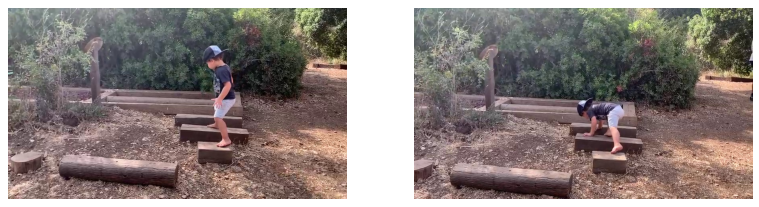

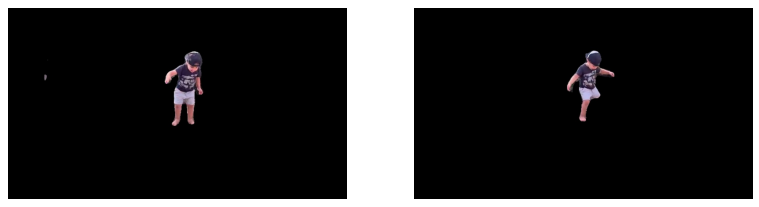

In [45]:
#Display Two Frames Images
Display_Two_Frames(OriginalImagesRoot)
#Display Segmented Images
Display_Two_Frames(SegmentImagesOutputRoot)

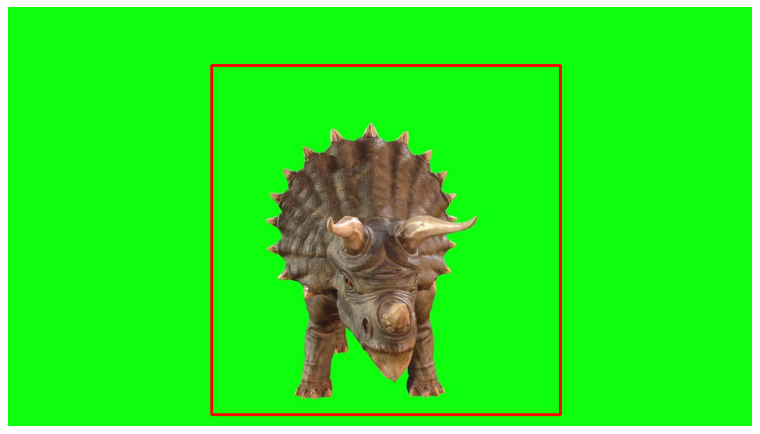

In [46]:
img = cv2.imread(r'my_data/PicsForReport/0006.jpg')

fig = plt.figure(figsize=(12, 10), dpi=80) 
# plot
ax = fig.add_subplot(1,1,1) 
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

# Start coordinate, here (5, 5)
# represents the top left corner of rectangle
start_point = (350,100)
  
# Ending coordinate, here (220, 220)
# represents the bottom right corner of rectangle
end_point = (950,700)
# Blue color in BGR
color = (255, 0, 0)
# Line thickness of 2 px
thickness = 3
  
# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
image = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), start_point, end_point, color, thickness)
# Create a Rectangle patch
ax.imshow(image)
plt.savefig(r'my_data/PicsForReport/GrubCutDinosurRect.jpg', bbox_inches='tight')  
plt.show()

In [47]:
# Video path to split into frames, Background to embbed and FolderHighLevelName

vid_path = r'my_data/Dinosur/Dinosur.mp4'
HighLevelName = 'Dinosur'
Model='Classic'
GrubCutRect = (265,100,635,570)
print(GrubCutRect)


# #Use to skip runing every time
# SegmentImagesOutputRoot = r'my_data/Dinosur/seg'
# OriginalImagesRoot = r'my_data/Dinosur/img'

SegmentImagesOutputRoot, OriginalImagesRoot = Sec3(vid_path,HighLevelName, _,Model, GrubCutRect)

(265, 100, 635, 570)


Display files ['0039.jpg', '0015.jpg', '0017.jpg', '0033.jpg', '0078.jpg']
Display files ['91.jpg', '43.jpg', '77.jpg', '84.jpg', '29.jpg']


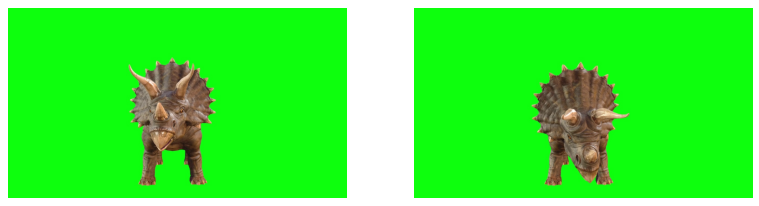

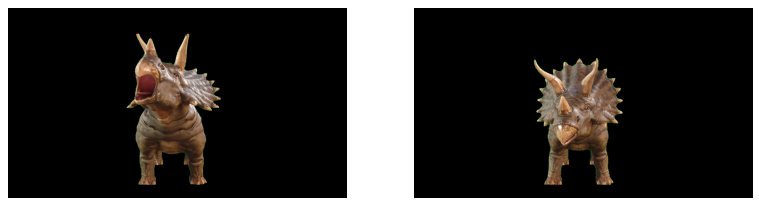

In [48]:
#Display Two Frames Images
Display_Two_Frames(OriginalImagesRoot)
#Display Segmented Images
Display_Two_Frames(SegmentImagesOutputRoot)

### Creating Video

In [49]:
VideoOffset1 = (50,200)
VideoOffset2 = (220,770)
VideoScale1 = (1,1)
VideoScale2 = (0.3,0.3)
FolderName = 'Embedding'
BackgroundPath = r'my_data/BackgroundImages/Clif.jpg'
SegmentImagesOutputRoot2 = r'my_data/Dinosur/seg'
SegmentImagesOutputRoot1 = r'my_data/MyVideo/seg'

EmbeddingFrames(SegmentImagesOutputRoot1,SegmentImagesOutputRoot2, BackgroundPath, 
                VideoOffset1, VideoOffset2, FolderName ,VideoScale1, VideoScale2)

(1200, 600)
writing video...
saved video @  ../output/Embedding_video.mp4
Finish Embedding


('my_data/Dinosur/seg',
 'my_data/Embedding/CombinationSegAndBackground',
 'my_data/Dinosur/img')

Display files ['0011.jpg', '0191.jpg', '0067.jpg', '0082.jpg', '0103.jpg']


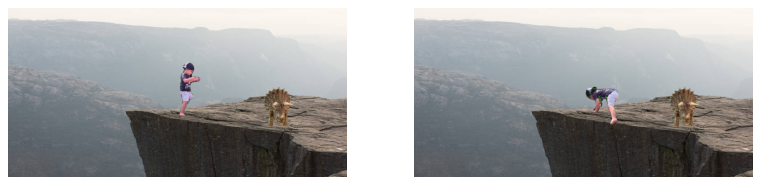

In [50]:
#Display Segmented Images
Display_Two_Frames(r'my_data/{}/CombinationSegAndBackground'.format(FolderName))